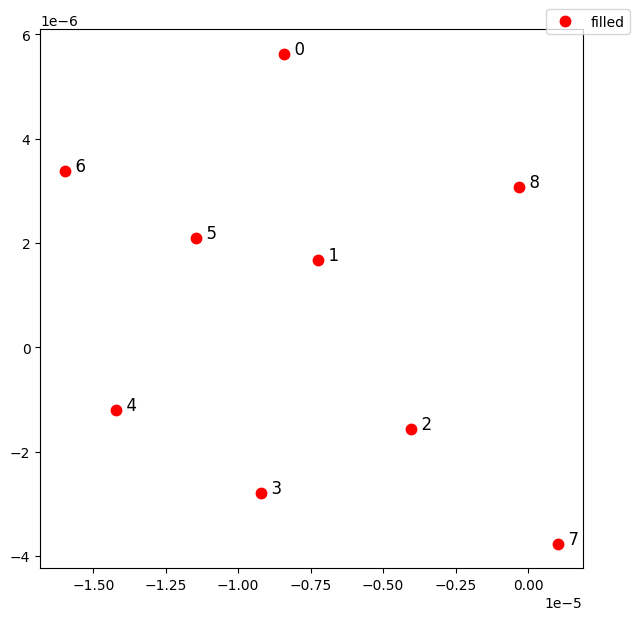

In [1]:
from braket.ahs.atom_arrangement import AtomArrangement
import numpy as np
from quera_ahs_utils.plotting import show_register
import matplotlib.pyplot as plt



points = [
(-1.380625,0.923125),
(-1.190625,0.273125),
(-0.660625,-0.256875),
(-1.510625,-0.456875),
(-2.330625,-0.196875),
(-1.880625,0.343125),
(-2.620625,0.553125),
(0.169375,-0.616875),
(-0.050625,0.503125),
]

a = 6.1e-6  # meters
N_atoms = len(points)

register = AtomArrangement()
for x,y in points:
    register.add([x*a, y*a])


fig = show_register(register)
plt.show()

### Hamiltonian

The next component we need to specify is the Hamiltonian. It's the energy function that governs the behaviour of our atoms, including their interactions. 

In the lab, the Hamiltonian is implemented by applying lasers to the atoms. 

In [2]:
from braket.ahs.hamiltonian import Hamiltonian

H = Hamiltonian()

Specifically, the Hamiltonian governing our system of atoms takes the following form:

\begin{align*}
H(t) = \frac{\Omega(t)}{2} \sum_j (e^{i \phi(t)}|{g_j}\rangle\langle{r_j}| +  e^{-i \phi(t)}|{r_j}\rangle\langle{g_j}|) - \sum_j \Delta(t)\hat{n}_j + \sum_{j<k} V_{jk}\hat{n}_j\hat{n}_k,
\end{align*}

where $\Omega$, $\phi$ and $\Delta$ denote the Rabi frequency, laser phase, and the detuning of the driving laser field coupling the ground states $|{g_j}\rangle$ and excited Rydberg state $|{r_j}\rangle$ of the j-th atom. Our task is to specify these Hamiltonian parameters ($\Omega$, $\phi$ and $\Delta$). Here, they will be time-dependent in order to help us carry out a protocol called adiabiatic state preparation. In case this sounds unfamiliar, feel free to read up on the physics background on our open source platform [Bloqade](https://queracomputing.github.io/Bloqade.jl/dev/tutorials/2.adiabatic/main/).


In our current case, we only want to tell the system to activate the set of lasers controlling the Rabi frequency and the global detuning. In particular, we will choose a constant Rabi frequency of $\Omega=2.5\times10^6$ rad/s and a linearly increasing detuning from $\Delta = -9\times10^6$ rad/s to $\Delta = 7\times10^6$ rad/s, together with a total time duration of $t = 4$ μs. The phase parameter will simply be set to zero. The rest of the code ensures that $\Omega$ and $\Delta$ are ramped on and off in a way compatible with the experimental setup.

In [3]:
def gaussian(t,T, A, sigma):
    return A*np.exp(-(t-T/2)**2/(2*sigma**2))

def exp(t, T, A):
    return A*np.exp(t/T)

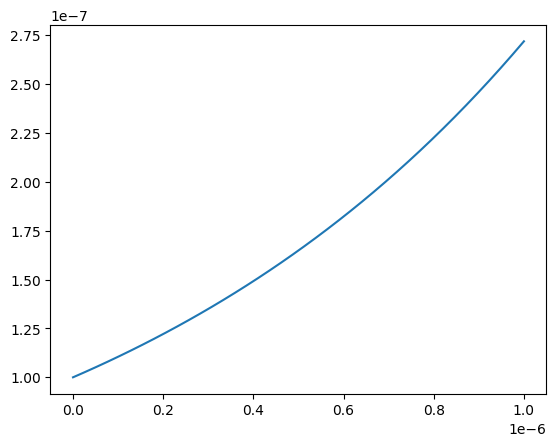

In [4]:
tlist = np.linspace(0, 1e-6, 40)
plt.plot(tlist, [exp(t, 1e-6, 1e-7) for t in tlist])

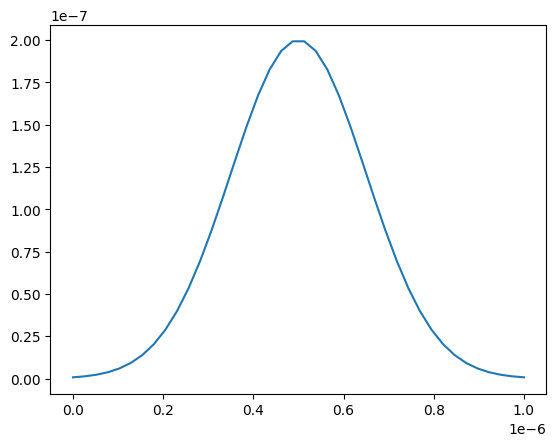

In [5]:
tlist = np.linspace(0, 1e-6, 40)
plt.plot(tlist, [gaussian(t, 1e-6, 2e-7, 1.5e-7) for t in tlist])

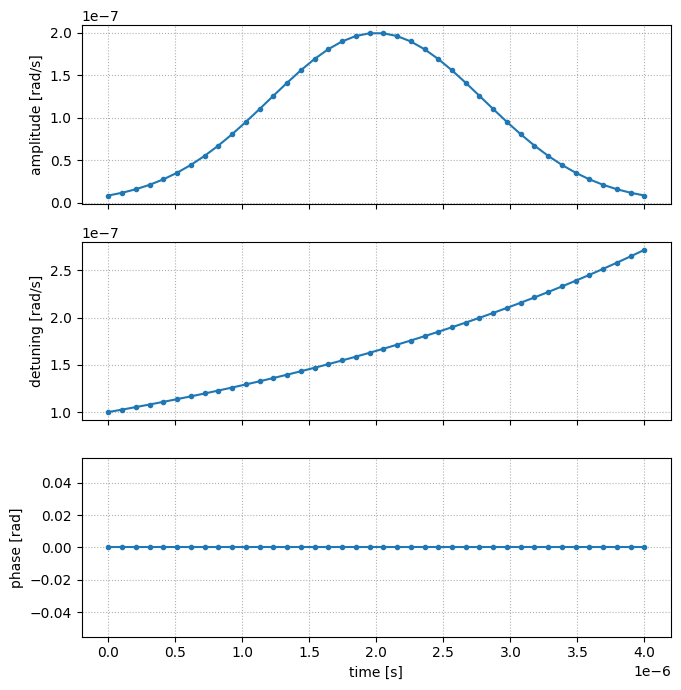

In [6]:
from quera_ahs_utils.plotting import show_global_drive 
from quera_ahs_utils.drive import get_drive

omega_min = 0       
omega_max = 2.5e6 * 2 * np.pi
detuning_min = -9e6 * 2 * np.pi
detuning_max = 7e6 * 2 * np.pi

time_max = 4e-6
time_ramp = 0.15*time_max

time_points = np.linspace(0, time_max, 40)
omega_values = [gaussian(t, 1e-6, 2e-7, 2e-7) for t in tlist]
detuning_values = [exp(t, 1e-6, 1e-7) for t in tlist]
phase_values = [0 for t in tlist]

drive = get_drive(time_points, omega_values, detuning_values, phase_values)
H += drive

show_global_drive(drive)
plt.show()

However, that's not the full story. These drive terms alone don't tell us how the atoms interact. But interactions are at the core of many-body quantum physics! That's where the Rydberg blockade comes in. Mathematically, it is described by the term

\begin{align*}
H_{interaction} = \sum_{j<k} V_{jk}\hat{n}_j\hat{n}_k
\end{align*}

in the Rydberg Hamiltonian. The key idea is that within a certain distance - the so-called blockade radius - only one atom will be excited into an $\ket{r}$ state. Having more excitations will cost too much energy. This means that the states of two neighboring atoms will depend on each other and exhibit specific patterns which we will plot below. Creating these ordered states is non-trivial. Following the [adiabatic protocol](https://queracomputing.github.io/Bloqade.jl/dev/tutorials/2.adiabatic/main/) mentioned previously is crucial since it allows us to slowly introduce these complex interactions into the system. 

<div class="alert alert-block alert-info">
    <b>Note: </b> In the current version of the AHS module in Braket, this Rydberg interaction term is automatically calculated from the atom positions. Hence, we don't need to worry about specifying it explicitly. Our Hamiltonian is all set!
</div>

### Defining the program (1D case)

Now, we can combine the register and Hamiltonian into a program. In particular, this program falls within the class of Analog Hamiltonian Simulation (AHS). If you're curious about other types of quantum computing, take a look at [gate-based circuits](https://github.com/aws/amazon-braket-examples/blob/main/examples/getting_started/1_Running_quantum_circuits_on_simulators/1_Running_quantum_circuits_on_simulators.ipynb) or tutorials on [quantum annealing](https://github.com/aws/amazon-braket-examples/blob/main/examples/quantum_annealing/Dwave_TravelingSalesmanProblem/Dwave_TravelingSalesmanProblem.ipynb).

In [7]:
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=H
)

### Simulation on classical hardware

Before submitting the task to run on actual quantum hardware, let's first check our program by running a local simulation on one of AWS's classical servers.

In [8]:
from braket.devices import LocalSimulator

classical_device = LocalSimulator("braket_ahs")

nshots = 1
task = classical_device.run(ahs_program, shots=nshots)

# The result can be downloaded directly into an object in the python session:
result = task.result()

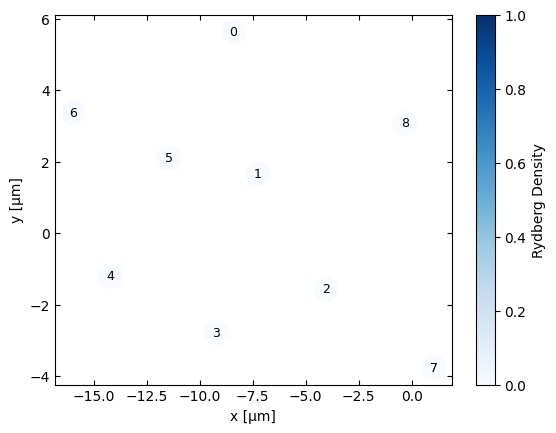

In [9]:
from quera_ahs_utils.analysis import get_avg_density
from quera_ahs_utils.plotting import plot_avg_density

n_rydberg = get_avg_density(result)
fig,ax = plot_avg_density(n_rydberg, register,cmap=plt.cm.Blues)
plt.show()